# XGBoost - Batch Transform - SageMaker SDK

## Download MNIST

In [1]:
%%time 
import pickle, gzip, urllib.request, json
import numpy as np

# Load the dataset
urllib.request.urlretrieve("http://deeplearning.net/data/mnist/mnist.pkl.gz", "mnist.pkl.gz")
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
print(train_set[0].shape)

(50000, 784)
CPU times: user 931 ms, sys: 355 ms, total: 1.29 s
Wall time: 2.71 s


In [2]:
!ls -l

total 15904
drwx------ 2 root     root        16384 May 22 02:10 lost+found
-rw-rw-r-- 1 ec2-user ec2-user 16168813 May 22 05:28 mnist.pkl.gz
-rw-rw-r-- 1 ec2-user ec2-user     9143 May 22 05:28 SageMaker-XGBoost-Host-SMSDK.ipynb
-rw-rw-r-- 1 ec2-user ec2-user    84888 May 22 05:11 SageMaker-XGBoost.ipynb


## Explorer

This is a 5


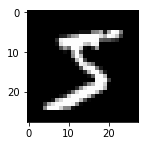

This is a 0


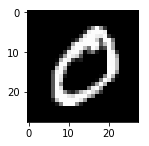

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (2,10)

for i in range(0, 2):
    img = train_set[0][i]
    label = train_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

## Upload Data to S3

In [4]:
%%time

import os
import boto3
import re
import copy
import time
import io
import struct
from time import gmtime, strftime
from sagemaker import get_execution_role

role = get_execution_role()

region = boto3.Session().region_name

bucket='bkt-sagemaker-source' # Replace with your s3 bucket name
prefix = 'sagemaker/xgboost-mnist' # Used as part of the path in the bucket where you store data

def convert_data():
    data_partitions = [('train', train_set), ('validation', valid_set), ('test', test_set)]
    for data_partition_name, data_partition in data_partitions:
        print('{}: {} {}'.format(data_partition_name, data_partition[0].shape, data_partition[1].shape))
        labels = [t.tolist() for t in data_partition[1]]
        features = [t.tolist() for t in data_partition[0]]
        
        if data_partition_name != 'test':
            examples = np.insert(features, 0, labels, axis=1)
        else:
            examples = features
        #print(examples[50000,:])
        
        
        np.savetxt('data.csv', examples, delimiter=',')
        
        
        
        key = "{}/{}/examples".format(prefix,data_partition_name)
        url = 's3://{}/{}'.format(bucket, key)
        boto3.Session().resource('s3').Bucket(bucket).Object(key).upload_file('data.csv')
        print('Done writing to {}'.format(url))
        
convert_data()

train: (50000, 784) (50000,)
Done writing to s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/train/examples
validation: (10000, 784) (10000,)
Done writing to s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/validation/examples
test: (10000, 784) (10000,)
Done writing to s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/test/examples
CPU times: user 38.5 s, sys: 5.75 s, total: 44.3 s
Wall time: 53.7 s


## Train a Model

### Create and Run a Training Job (Amazon SageMaker Python SDK)

Obteniendo la imagen SageMaker XGBoost

In [5]:
import sagemaker

from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost', '0.90-1')

Configurando la ruta del datasets MNIST y la ruta para los artefactos del modelo entrenado

In [6]:
train_data = 's3://{}/{}/{}'.format(bucket, prefix, 'train')

validation_data = 's3://{}/{}/{}'.format(bucket, prefix, 'validation')

s3_output_location = 's3://{}/{}/{}'.format(bucket, prefix, 'xgboost_model_sdk')

print(train_data)

s3://bkt-sagemaker-source/sagemaker/xgboost-mnist/train


Creando la instancia de entrenamiento dedicado (dedicated training instance)

In [7]:
xgb_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.m4.xlarge',
                                         train_volume_size = 5,
                                         output_path=s3_output_location,
                                         sagemaker_session=sagemaker.Session())

Configuracion de los hyperparametros del Training Job

In [8]:
xgb_model.set_hyperparameters(max_depth = 5,
                              eta = .2,
                              gamma = 4,
                              min_child_weight = 6,
                              silent = 0,
                              objective = "multi:softmax",
                              num_class = 10,
                              num_round = 10)

Creando los canales de datos para usar en el Trainig Job

In [9]:
train_channel = sagemaker.session.s3_input(train_data, content_type='text/csv')
valid_channel = sagemaker.session.s3_input(validation_data, content_type='text/csv')

data_channels = {'train': train_channel, 'validation': valid_channel}

Entrenando el Modelo

In [10]:
xgb_model.fit(inputs=data_channels,  logs=True)

2020-05-22 05:37:02 Starting - Starting the training job...
2020-05-22 05:37:04 Starting - Launching requested ML instances.........
2020-05-22 05:38:33 Starting - Preparing the instances for training...
2020-05-22 05:39:33 Downloading - Downloading input data......
2020-05-22 05:40:24 Training - Downloading the training image...
2020-05-22 05:40:42 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[05:40:51] 50000x784 matrix with 39200000 entries loaded from /o

## Deploy a Model

### Deploy a Model with Batch Transform (Amazon SageMaker High-level Python Library)

El despliegue del modelo consiste primero en obtener los datos de entrada (test set), ejecutar las predicciones de los datos y almacenar los resultados de la prediccion.

In [ ]:
# The location of the test dataset
batch_input = 's3://{}/{}/test/examples'.format(bucket, prefix)

# The location to store the results of the batch transform job
batch_output = 's3://{}/{}/batch-inference'.format(bucket, prefix)

transformer = xgb_model.transformer(instance_count=1, instance_type='ml.m4.xlarge', output_path=batch_output)

transformer.transform(data=batch_input, data_type='S3Prefix', content_type='text/csv', split_type='Line')

transformer.wait()

Using already existing model: sagemaker-xgboost-2020-05-22-05-37-02-382


............

## Validate a Model

Download test data to S3

In [ ]:
s3 = boto3.resource('s3')

test_key = "{}/test/examples".format(prefix)

s3.Bucket(bucket).download_file(test_key, 'test_data')

In [ ]:
!ls

Visualizando los datos de prueba (test set)

In [ ]:
%matplotlib inline
                        
for i in range (0, 3):
    img = test_set[0][i]
    label = test_set[1][i]
    img_reshape = img.reshape((28,28))
    imgplot = plt.imshow(img_reshape, cmap='gray')
    print('This is a {}'.format(label))
    plt.show()

Descargar el resultado de la prediccion en lote (Resultado de la operacion de despliegue)

In [ ]:
s3.Bucket(bucket).download_file(prefix + '/batch-inference/examples.out',  'batch_results')

In [ ]:
Visualizando los resultado de la prediccion

In [ ]:
with open('batch_results') as f:
    results = f.readlines()
for j in range (0, 3):
    print(results[j])